<a href="https://www.kaggle.com/code/nigamshitij/exploratory-crop-disease-classifiers?scriptVersionId=177000251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
# # boilerplate
# !pip install -Uqq fastkaggle

basic image size:  (480, 640)


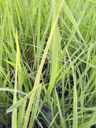

In [9]:
from fastai.vision.all import *
set_seed(42)

# set paths
path = Path('/kaggle/input/paddy-disease-classification')
path.ls()

# set training path
training_path = path/'train_images'
image_files = get_image_files(training_path)

# grab one image to test
img = PILImage.create(image_files[1])
print("basic image size: ", img.size)
img.to_thumb(128)

In [10]:
# check all image sizes in parallel
from fastcore.parallel import *

def size(i):
    return PILImage.create(i).size

# sizes = parallel()
img_sizes = parallel(
    f = size,
    items = image_files,
    n_workers = 8
)

# print sizes
pd.Series(img_sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

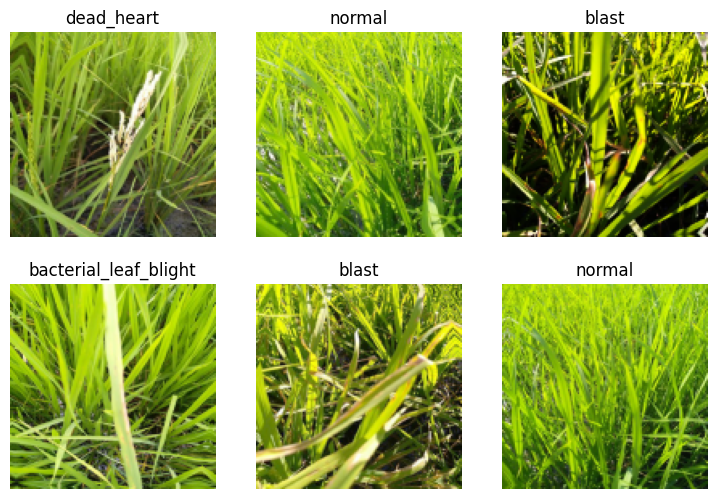

In [11]:
# ImageDataLoaders.from_folder??
# create batch dataloader using fast.ai
dataloaders = ImageDataLoaders.from_folder(
    path = training_path,
    valid_pct = 0.2, # set aside 20% for validation
    seed = 42, # set random seed manually
    item_tfms = Resize(480, method = 'squish'), # resize everything to 480
    batch_tfms = aug_transforms(size = 128, min_scale = 0.75) # add augmentation to batch
)

dataloaders.show_batch(max_n = 6)

In [12]:
# models from here https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning
# selected resnet26d due to fastest time

# create basic resnet model
learner = vision_learner(
    dls = dataloaders,
    arch = 'resnet26d', # architecture
    metrics = error_rate,
    path = '.'
).to_fp16()

# find learning rates
# learner.lr_find(suggest_funcs = (valley, slide))
valley = .0010000000474974513
slide = .0063095735386013985
lr = (valley+slide)/2

# fine tune
learner.fine_tune(epochs = 3, base_lr = 0.01)

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.768258,1.222303,0.389236,00:56


epoch,train_loss,valid_loss,error_rate,time
0,1.186733,0.752554,0.251802,00:57
1,0.802751,0.446072,0.149928,00:57
2,0.538108,0.383562,0.128304,00:56


In [13]:
# import torch
# torch.cuda.empty_cache()
# learner.get_preds??
# learner.lr_find(suggest_funcs = (valley, slide))

In [14]:
# learner.fine_tune??

# get test files
test_files = get_image_files(path/'test_images').sorted()

# get exact same dataloader for test files via test_dl function
test_dataloaders = dataloaders.test_dl(test_files)

# get probabilities and indexes
probabilities,_, indexes = learner.get_preds(
    dl = test_dataloaders,
    with_decoded = True
)

# map indexes (indexes) to vocabulary (dataloaders.vocab)
mapping = dict(enumerate(dataloaders.vocab))
results = pd.Series(indexes.numpy(), name = "indexes").map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: indexes, Length: 3469, dtype: object

In [15]:
# learner.get_preds??
# create csv

# read sample submission
sample_submission = pd.read_csv(path/'sample_submission.csv')

# add label 
sample_submission['label'] = results
sample_submission.to_csv('subm.csv', index = False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


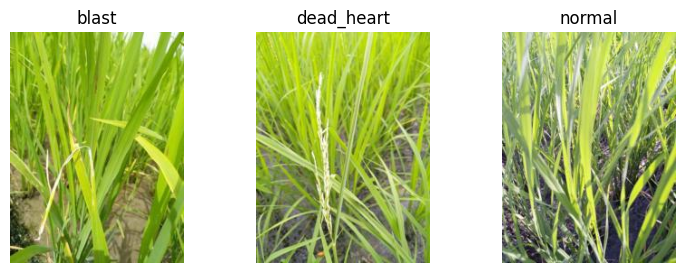

In [16]:
# resize and operate on smaller images

# create new path for training pictures
training_path_small = Path('small')

# run resize images using trained images on new path
resize_images(
    path = path/'train_images',
    dest = training_path_small,
    max_size = 256,
    recurse = True
)

# create dataloader from smaller versions
small_dataloaders = ImageDataLoaders.from_folder(
    training_path_small,
    valid_pct = 0.2,
    seed = 42,
    item_tfms = Resize((256, 192))
)

# show batch
small_dataloaders.show_batch(max_n = 3)

In [17]:
# resize_images??
# vision_learner??
# learner.fine_tune??

In [18]:
def training_function(architecture, item_transformer, batch_transformer, num_epochs = 5):
    dataloaders = ImageDataLoaders.from_folder(
        path = training_path_small,
        valid_pct = 0.2,
        seed = 42,
        item_tfms = item_transformer,
        batch_tfms = batch_transformer
    )
    learner = vision_learner(
        dls = dataloaders,
        arch = architecture,
        metrics = error_rate
    ).to_fp16()
    learner.fine_tune(
        epochs = num_epochs,
        base_lr = 0.01
    )
    return learner

# create an instance with 5 epochs of training
learner_instance = training_function(
    architecture = 'resnet26d',
    item_transformer = Resize(192),
    batch_transformer = aug_transforms(size = 128, min_scale = 0.75)
)

epoch,train_loss,valid_loss,error_rate,time
0,1.959264,1.410313,0.443056,00:18


epoch,train_loss,valid_loss,error_rate,time
0,1.294200,1.024875,0.341663,00:20
1,1.035003,0.700737,0.223450,00:20
2,0.714693,0.504827,0.157617,00:20
3,0.527736,0.394031,0.127343,00:20
4,0.446370,0.369136,0.116771,00:20


In [47]:
import timm
timm.__version__

'0.9.16'

In [48]:
import torch
torch.cuda.empty_cache()

In [49]:
# try swin
conv_learner_instance = training_function(
    architecture = 'convnext_small_in22k', # lowest error rate
    item_transformer = Resize(192, method = 'squish'),
    batch_transformer = aug_transforms(size = 128, min_scale = 0.75)
)

epoch,train_loss,valid_loss,error_rate,time
0,1.304773,0.825658,0.255646,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.628778,0.436822,0.136953,00:33
1,0.514978,0.427246,0.130226,00:32
2,0.313949,0.222094,0.070159,00:33
3,0.176245,0.184868,0.053340,00:33
4,0.114289,0.182077,0.053820,00:33


In [50]:
# try cropping instead of squishing
conv_learner_instance = training_function(
    architecture = 'convnext_small_in22k',
    item_transformer = Resize(192, method = 'crop'),
    batch_transformer = aug_transforms(size = 128, min_scale = 0.75)
)

epoch,train_loss,valid_loss,error_rate,time
0,1.324075,0.833780,0.256607,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.681292,0.500066,0.157617,00:32
1,0.587384,0.387124,0.126382,00:32
2,0.370603,0.273746,0.083614,00:32
3,0.226806,0.210235,0.063912,00:33
4,0.159051,0.194927,0.061028,00:34


In [51]:
# try padding
padded_dataloaders = ImageDataLoaders.from_folder(
    training_path_small,
    valid_pct = 0.2,
    seed = 42,
    item_tfms = Resize(192, method = ResizeMethod.Pad, pad_mode = PadMode.Zeros)
)

# padded_dataloaders.show_batch(max_n = 3)

# create padding learner using aforementioned tests (skip batching for re-run)
padded_learner = training_function(
    architecture = 'convnext_small_in22k',
    item_transformer = Resize(192, method = ResizeMethod.Pad, pad_mode = PadMode.Zeros),
    batch_transformer = aug_transforms(size = (171, 128), min_scale = 0.75)
)

epoch,train_loss,valid_loss,error_rate,time
0,1.462702,1.009598,0.311869,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.721946,0.503319,0.171072,00:37
1,0.522565,0.392128,0.126862,00:37
2,0.350927,0.282740,0.087458,00:38
3,0.195171,0.225984,0.063912,00:38
4,0.155024,0.199824,0.060067,00:37


Error rate:  TensorBase(0.0601)


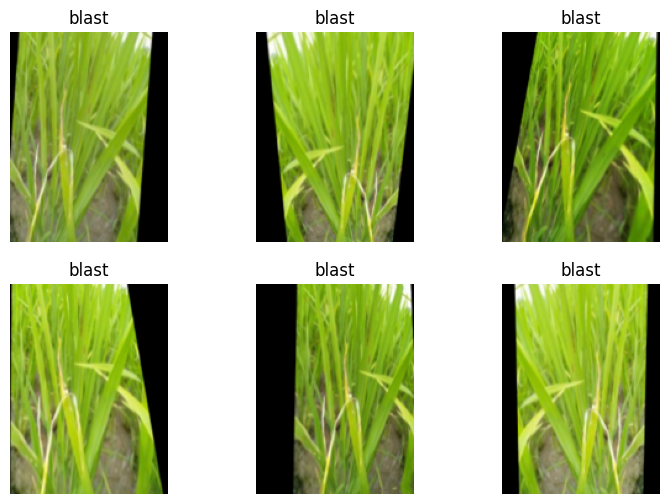

In [52]:
# test time augmentation

# check pre-tta error rate
validation_dataloader = padded_learner.dls.valid
predictions, targets = padded_learner.get_preds(dl = validation_dataloader)
print("Error rate: ", error_rate(predictions, targets))

# add augmentations
padded_learner.dls.train.show_batch(max_n = 6, unique = True)

In [53]:
tta_predictions, _ = padded_learner.tta(dl = validation_dataloader)
print("Error rate: ", error_rate(tta_predictions, targets))

Error rate:  TensorBase(0.0471)


In [54]:
# scale up to larger images
large_training_path = path/'train_images'
architecture = 'convnext_small_in22k'

# create dataloaders and learning function with 1 epoch; resize (larger images), pad, augment
large_learner = training_function(
    architecture = architecture,
    item_transformer = Resize((480, 360), method = ResizeMethod.Pad, pad_mode = PadMode.Zeros),
    batch_transformer = aug_transforms(size = (256, 192), min_scale = 0.75)
)

# get predictions based on validation data to get error rate
tta_predictions, targets = large_learner.tta(dl = large_learner.dls.valid)
print("New Error Rate: ", error_rate(tta_predictions, targets))

epoch,train_loss,valid_loss,error_rate,time
0,1.219959,0.772555,0.247477,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.609551,0.413474,0.130706,01:16
1,0.465967,0.313425,0.091783,01:17
2,0.281733,0.233399,0.064392,01:16
3,0.170597,0.183265,0.049976,01:16
4,0.114715,0.164352,0.044690,01:16


New Error Rate:  TensorBase(0.0428)


In [55]:
# turn model into submission files using test image data
test_image_files = get_image_files(path/'test_images').sorted()
test_dataloader = large_learner.dls.test_dl(test_image_files)

# do a tta on that test set
predictions, _ = large_learner.tta(dl = test_dataloader)

In [56]:
# get indexes based on argmax
indexes = predictions.argmax(dim = 1)

# get vocabulary
vocab = np.array(large_learner.dls.vocab)
results = pd.Series(vocab[indexes], name = "idxs")

# convert to csv
submission_sample = pd.read_csv(path/'sample_submission.csv')
submission_sample['label'] = results
submission_sample.to_csv('subm_2.csv', index = False)
!head subm_2.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


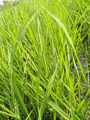

In [57]:
# quick data checks
PILImage.create(test_image_files[1]).to_thumb(120)

In [58]:
# testing gradient accumulation

# get training dataframe
training_dataframe = pd.read_csv(path/'train.csv')

# get lowest value for testing
training_dataframe.label.value_counts() 

# bacterial_panicle_blight is lowest # - 337
lowest_training_path = path/'train_images'/'bacterial_panicle_blight'

# cbs = callbacks: cbs is one or a list of Callbacks to pass to the Learner
# Callbacks are used for every tweak of the training loop
# Each Callback is registered as an attribute of Learner (with camel case)
# At creation, all the callbacks in defaults.callbacks ..
# .. (TrainEvalCallback, Recorder, ProgressCallback) are associated to the Learner.
# useful for breaking before / after step function, etc. during training loops

# define training function 
def train(architecture, 
          batch_tfm_size, 
          item_transformer = Resize(480, method = 'squish'), 
          gradient_accumulation = 1, 
          finetune = True, 
          num_epochs = 12):
    
    dataloaders = ImageDataLoaders.from_folder(
        path = lowest_training_path,
        valid_pct = 0.2,
        # seed = 42, remove it to ensure batches are random (for ensembling later)
        item_tfms = item_transformer,
        batch_tfms = aug_transforms(size = batch_tfm_size, min_scale = 0.75),
        bs = 64//gradient_accumulation
    )
    
    callbacks = GradientAccumulation(n_acc = 64) if gradient_accumulation else []
    
    learner = vision_learner(
        dls = dataloaders,
        arch = architecture,
        metrics = error_rate,
        cbs = callbacks
    ).to_fp16() # convert to float because sigmoid / softmax doesn't work for int

    if finetune:
        learner.fine_tune(
            epochs = num_epochs,
            base_lr = 0.01
        )
        return learner.tta(dl = dataloaders.test_dl(test_image_files))
    else:
        learner.unfreeze()
        learner.fit_one_cycle(
            n_epoch = num_epochs,
            lr_max = 0.01
        )
    return learner

In [59]:
# GradientAccumulation??

# train for one epoch to test if function works
train(
    architecture = 'convnext_small_in22k',
    batch_tfm_size = 128,
    num_epochs = 1,
    gradient_accumulation = 1,
    finetune = False
)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:03


In [60]:
# memory usage + clearance
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

report_gpu() # test for 1 gradient accumulation

GPU:0
process       3208 uses    11268.000 MB GPU memory


In [61]:
# # clean up cache before running
# report_gpu()

In [62]:
torch.cuda.empty_cache()
import gc
# del variable
gc.collect()

0

In [63]:
# running out of memory; use larger GPUs

# train(
#     architecture = 'convnext_large_in22k',
#     batch_tfm_size = (320,240),
#     num_epochs = 1,
#     gradient_accumulation = 2,
#     finetune = False
# )
# report_gpu()
# torch.cuda.empty_cache()

# ensembling
res = 640,480

# train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
ensemble_models = {
    'convnext_small_in22k': {(Resize(480, method = 'squish'), 128)},
#     'convnext_large_in22k': {(Resize(res), (320,224))},
#     'vit_large_patch16_224': {(Resize(480, method = 'squish'), 224), (Resize(res), 224)},
#     'swinv2_large_windows12_192_22k': {(Resize(480, method = 'squish'), 192), (Resize(res), 192)},
#     'swin_large_patch4_windows7_224': {(Resize(res), 224), }
}

training_path = path/'train_images'
tta_results = []

for architecture, details in ensemble_models.items():
    for item_tfmr, size in details:
        print('--', architecture)
        print(size)
        print(item_tfmr.name)
        tta_results.append(train(architecture = architecture, batch_tfm_size = size, item_transformer = item_tfmr, gradient_accumulation = 2))
        # memory clear
        gc.collect()
        torch.cuda.empty_cache()

-- convnext_small_in22k
128
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:02
1,0.000000,0.000000,0.000000,00:02
2,0.000000,0.000000,0.000000,00:02
3,0.000000,0.000000,0.000000,00:03
4,0.000000,0.000000,0.000000,00:02
5,0.000000,0.000000,0.000000,00:02
6,0.000000,0.000000,0.000000,00:02
7,0.000000,0.000000,0.000000,00:02
8,0.000000,0.000000,0.000000,00:02
9,0.000000,0.000000,0.000000,00:02


In [64]:
# save results
save_pickle('tta_results.pkl', tta_results)

tta_predictions = first(zip(*tta_results))
# tta_predictions += tta_predictions[1:3] () -- for ensembles, vary size

In [65]:
# check shape (should be higher dimensions for more models)
avg_predictions = torch.stack(tta_predictions).mean(0)
avg_predictions.shape

torch.Size([3469, 1])

In [66]:
# create ensemble predictions dl + file for submission

# create dataloader for training data (needed for vocab)
dataloaders = ImageDataLoaders.from_folder(
    path = training_path,
    valid_pct = 0.2,
    item_tfms = Resize(480, method = 'squish'),
    batch_tfms = aug_transforms(size = 224, min_scale = 0.75)
)

# get indexes for prediction using max argument
indexes = avg_predictions.argmax(dim = 1)

# pick vocabulary from training data
vocab = np.array(dataloaders.vocab)

# write submission sample csv into a dataframe
submission_sample = pd.read_csv(path/'sample_submission.csv')

# add label based on vocab from training data combined with argmax indices using avg predictions
submission_sample['label'] = vocab[indexes]

# convert to csv :-)
submission_sample.to_csv('subm_ensemble.csv', index = False)

!head subm_ensemble.csv

image_id,label
200001.jpg,bacterial_leaf_blight
200002.jpg,bacterial_leaf_blight
200003.jpg,bacterial_leaf_blight
200004.jpg,bacterial_leaf_blight
200005.jpg,bacterial_leaf_blight
200006.jpg,bacterial_leaf_blight
200007.jpg,bacterial_leaf_blight
200008.jpg,bacterial_leaf_blight
200009.jpg,bacterial_leaf_blight


In [67]:
report_gpu()

GPU:0
process       3208 uses     9070.000 MB GPU memory


In [68]:
# try multi output

training_path = path/'train_images'

training_dataframe = pd.read_csv(path/'train.csv', index_col = 'image_id')
print(training_dataframe.head())
print(training_dataframe.describe())
print(training_dataframe.loc['100330.jpg', 'variety'])

                            label variety  age
image_id                                      
100330.jpg  bacterial_leaf_blight   ADT45   45
100365.jpg  bacterial_leaf_blight   ADT45   45
100382.jpg  bacterial_leaf_blight   ADT45   45
100632.jpg  bacterial_leaf_blight   ADT45   45
101918.jpg  bacterial_leaf_blight   ADT45   45
                age
count  10407.000000
mean      64.043624
std        8.958830
min       45.000000
25%       60.000000
50%       67.000000
75%       70.000000
max       82.000000
ADT45


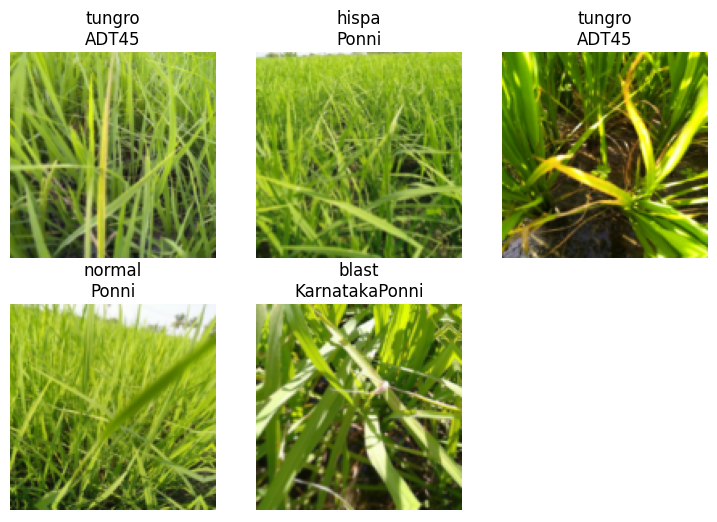

In [69]:
# def parent_label is defined within fast_ai

def get_variety(image_path):
    #image_path.name should give file name
    return training_dataframe.loc[image_path.name, 'variety']

# create datablock
multivariate_datablock = DataBlock(
    blocks = (ImageBlock, CategoryBlock, CategoryBlock),
    n_inp = 1, # ensures ImageBlock is the only input, rest are outputs
    get_items = get_image_files,
    get_y = [parent_label, get_variety], # dependent variable functions
    splitter = RandomSplitter(0.2, seed = 42),
    item_tfms = Resize(192, method = 'squish'),
    batch_tfms = aug_transforms(size = 128, min_scale = 0.75)
)

# load data from training path into dataloader
multivariate_dataloaders = multivariate_datablock.dataloaders(training_path)

# show batch :)
multivariate_dataloaders.show_batch(max_n = 5)

In [70]:
# DataBlock??

# error rate for disease separately defined
# 3 variables are passed in - error rate is calculated on 2
# inp - CategoryBlock?, disease - CategoryBlock, variety - CategoryBlock?
def disease_error(inp, disease, variety):
    return error_rate(inp, disease)

# loss function for disease is separately defined
# 3 variables are passed in - cross entropy loss is calculated for 2
# inp - CategoryBlock?, disease - CategoryBlock, variety - CategoryBlock?
def disease_loss(inp, disease, variety):
    return F.cross_entropy(inp, disease)

architecture = 'convnext_small_in22k'

multivariate_learner = vision_learner(
    dls = multivariate_dataloaders,
    arch = architecture,
    loss_func = disease_loss,
    metrics = disease_error, # not error rate, since there are now 2 variables
    n_out = 10
).to_fp16()

learning_rate = 0.01

multivariate_learner.fine_tune(
    epochs = 5,
    base_lr = learning_rate
)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,disease_error,time
0,1.244274,0.819936,0.274868,00:42


epoch,train_loss,valid_loss,disease_error,time
0,0.623527,0.436948,0.130706,00:44
1,0.483067,0.278348,0.093224,00:44
2,0.314023,0.240113,0.075925,00:44
3,0.189602,0.146647,0.040846,00:45
4,0.137158,0.139962,0.041326,00:44


In [71]:
# Learner.fine_tune??
learning_rate = 0.01

# define individual & total lsos functions
def disease_loss(inp, disease, variety):
    return F.cross_entropy(inp[:, :10], disease)

def variety_loss(inp, disease, variety):
    return F.cross_entropy(inp[:, 10:], variety)

def combined_loss(inp, disease, variety):
    total_loss = disease_loss(inp, disease, variety) + variety_loss(inp, disease, variety)
    return total_loss

# define individual and 'combined' rate functions
def disease_error_rate(inp, disease, variety):
    return error_rate(inp[:, :10], disease)

def variety_error_rate(inp, disease, variety):
    return error_rate(inp[:, 10:], variety)

error_rates = (disease_error_rate, variety_error_rate)

# define learner with new 
multivariate_learner_2 = vision_learner(
    dls = multivariate_dataloaders,
    arch = architecture,
    loss_func = combined_loss, # now we need loss for both disease & variety
    metrics = error_rates, # now we need error rates for both disease & variety
    n_out = 20
).to_fp16()

multivariate_learner_2.fine_tune(epochs = 5, base_lr = learning_rate)

epoch,train_loss,valid_loss,disease_error_rate,variety_error_rate,time
0,2.277807,1.131920,0.248919,0.118212,00:41


epoch,train_loss,valid_loss,disease_error_rate,variety_error_rate,time
0,1.004606,0.559089,0.134070,0.047093,00:45
1,0.767285,0.356208,0.082172,0.032196,00:45
2,0.472242,0.271703,0.062951,0.022585,00:45
3,0.296065,0.179391,0.042287,0.013936,00:45
4,0.199087,0.153468,0.038924,0.010572,00:45
